In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactiveity = 'all'

import numpy as np
import pandas as pd
import torch
import yfinance as yf
import hmmlearn.hmm as hmm
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn; seaborn.set()
import utils as u
import feature_generation as fg
import statsmodels.api as sm

**Model Assumptions**
- 分布观察: Normality Test, QQ Plot (Quantile-Quantilt Plot), 箱型图观察变量在时间序列上分布   
- Stationary Test: ADF test (Augmented Dickey-Fuller Test), tests the null hypothesis that a unit root is present in a time series
- Granger Causality（f test）: determining whether one time series is influential on another
- (Spearman) Correlation Matrix

**OLS**  
**Residual Analysis**

- Multicollinearity: VIF(variance inflation factor), an index that measures how much the variance of an estimated regression coefficient is increased because of collinearity. ---- 岭回归/正交化/PCA解决
- heteroscedasticity： White test, whether the variance of the errors in a regression model is constant
- Autocorrelation: DW Test(Durbin–Watson statistic),  detect the presence of autocorrelation in the residuals 


In [2]:
"""罗素3000价格数据"""
vthr = pd.read_excel("Data/VTHR.xlsx", parse_dates =["Date"], index_col ="Date")
vthr.sort_values(by='Date', inplace=True)
vthr = vthr.dropna()
vthr.rename(columns={'Last Price':'Price'}, inplace=True)
vthr.head()

,Price,Volume,SMAVG (15)
Date,,,
1995-02-21,275.531,401336096.0,294167456.0
1995-02-22,276.745,434374496.0,302946016.0
1995-02-23,278.067,527060896.0,315761152.0
1995-02-24,278.541,416102496.0,324997472.0
1995-02-27,276.282,362187296.0,323281088.0


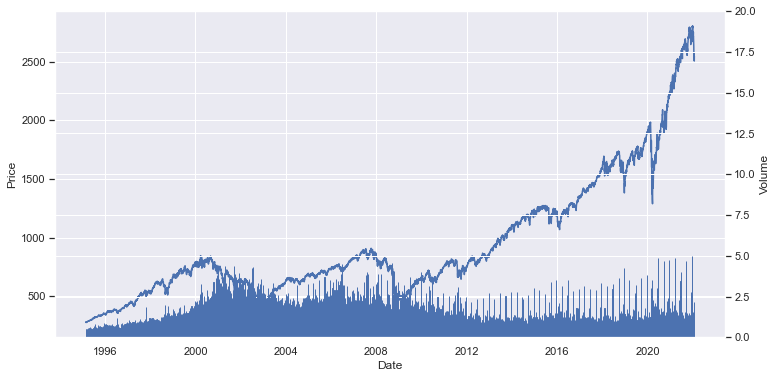

In [5]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.plot(vthr['Price'])
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.bar(vthr.index, vthr['Volume']/1e9, edgecolor='b')
ax2.set_ylim([0,20])
ax2.set_ylabel('Volume')

fig.show()

In [31]:
"""加载宏观经济数据"""
#quartly
gdp = pd.read_csv('Data/GDP.csv', header=1, names=['Date', 'GDP'])
readgdp = pd.read_csv('Data/GDPC1_RealGDP.csv', names=['Date', 'GDP_real'])

#monthly
#M2. M3, unemployment rate, PMI, PPI, CPI
M2 = pd.read_csv('Data/M2.csv', header=1, names=['Date', 'M2'], parse_dates =["Date"], index_col ="Date")
M3 = pd.read_csv('Data/M3.csv', header=1, names=['Date', 'M3'], parse_dates =["Date"], index_col ="Date")
unrate = pd.read_excel("Data/Unemployment Rate .xls", names=['Date', 'Unrate'], parse_dates =["Date"], index_col ="Date")[10:]
PMI = pd.read_excel("Data/PMI.xlsx",header=1, names=['Date', 'PMI_R1', 'PMI_L1'], parse_dates =["Date"], index_col ="Date")
PPI = pd.read_csv('Data/PPIACO.csv', header=1, names=['Date', 'PPI'], parse_dates =["Date"], index_col ="Date")
CPI = pd.read_csv('Data/CPI_AUCSL.csv', header=1, names=['Date', 'CPI'], parse_dates =["Date"], index_col ="Date")

monthly_list = [M2, M3, unrate, PMI, PPI, CPI]


#weekly
M1 = pd.read_csv('Data/M1.csv', header=1, names=['Date', 'M1'])

#daily
#VIX，10Y美债利率， 3Ycorperate spread
VIX = pd.read_csv('Data/VIXCLS.csv', header=1, names=['Date', 'VIX'], parse_dates =["Date"], index_col ="Date") 
# Gold = pd.read_excel("Data/Gold.xlsx", header=2, parse_dates =["Date"], names = ['Date','Gold', 'OpenInt', 'Avg15_gold'], index_col ="Date")
# Gold.sort_values(by='Date', inplace=True)
# Crude = pd.read_excel("Data/Crude_WTI.xlsx", header=2, names = ['Date','Crude', 'OpenInt', 'Avg15_gold'], parse_dates =["Date"], index_col ="Date")
# Crude.sort_values(by='Date', inplace=True)
US10Y = pd.read_csv('Data/US10Y.csv', header=2, names=['Date', 'US10Y'], parse_dates =["Date"], index_col ="Date") 
US10Y[US10Y['US10Y'] == '.'] = np.NaN
US10Y['US10Y'] = US10Y['US10Y'].astype('float')
CorpSpread3Y = pd.read_csv('Data/CorpSpread3Y.csv', header=2, names=['Date', 'CorpSpread3Y'], parse_dates =["Date"], index_col ="Date") 
CorpSpread3Y[CorpSpread3Y['CorpSpread3Y'] == '.'] = np.NaN
CorpSpread3Y['CorpSpread3Y'] = CorpSpread3Y['CorpSpread3Y'].astype('float')
weekly_list = [US10Y, CorpSpread3Y]

In [39]:
"""合并月度指标"""
monthly = M2.join(M3, how='inner')
for i in monthly_list[2:]:
    i.index = pd.to_datetime(pd.to_datetime(i.index).strftime("%Y-%m"))
    monthly = monthly.join(i,how='inner')
    
for i in weekly_list:
    tmp = i.resample("M").mean()
    tmp.index = pd.to_datetime(tmp.index.strftime("%Y-%m"))
    monthly = monthly.join(tmp,how='inner')
    
monthly = monthly.dropna()
monthly.head()    

,M2,M3,Unrate,PMI_R1,PMI_L1,PPI,CPI,US10Y,CorpSpread3Y
Date,,,,,,,,,
1997-07-01,3923.9,3.923900e+12,4.9,57.7,56.675,126.9,160.4,6.220455,0.407727
1997-08-01,3957.4,3.957400e+12,4.8,56.3,62.025,127.2,160.8,6.298571,0.408182
1997-09-01,3973.1,3.973100e+12,4.9,53.9,56.150,127.5,161.2,6.208571,0.420476
1997-10-01,3992.3,3.992300e+12,4.7,56.4,56.600,127.8,161.5,6.029545,0.423913
1997-11-01,4014.8,4.014800e+12,4.6,55.7,58.500,127.9,161.7,5.875000,0.504286


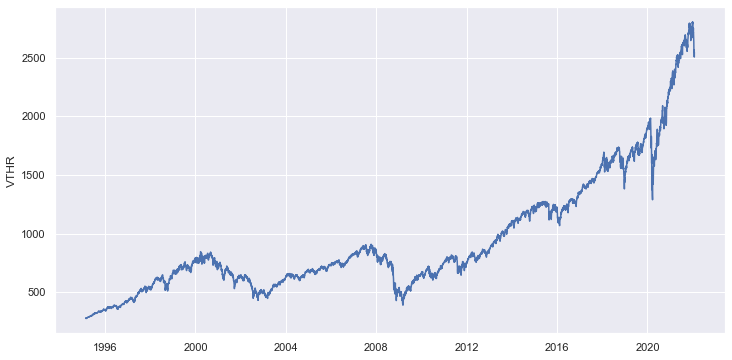

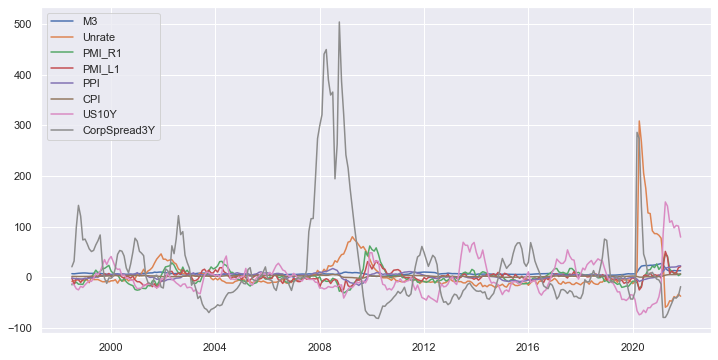

In [40]:
#计算同比数据
for i in monthly.columns[1:]:
    monthly[i] = monthly[i].pct_change(periods=12)*100
    
monthly = monthly.dropna()

plt.figure(figsize=(12, 6))
plt.plot(vthr['Price'])
plt.ylabel('VTHR')
plt.show()

plt.figure(figsize=(12, 6))
for i in monthly.columns[1:]:
    plt.plot(monthly[i], label=i)
plt.legend()    
plt.show()

## Check normality (QQ Plot)

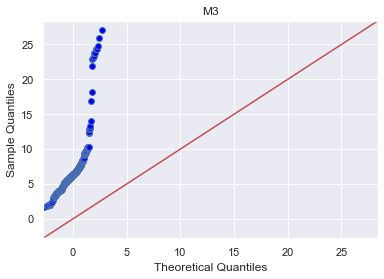

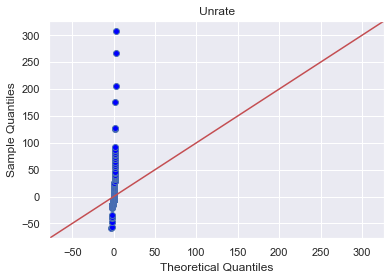

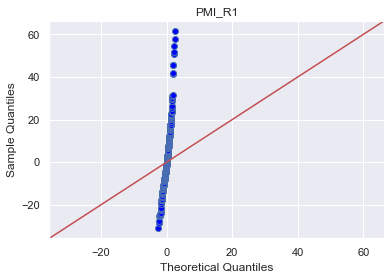

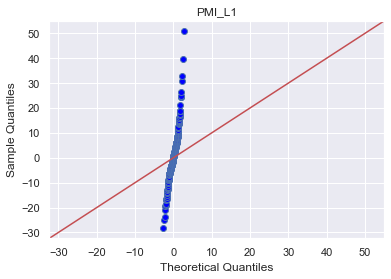

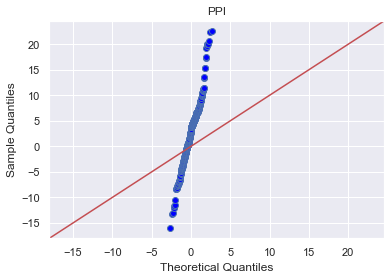

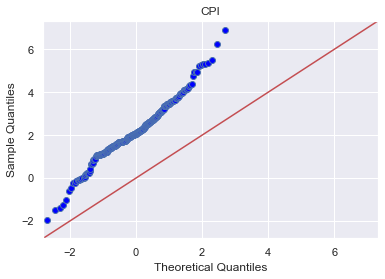

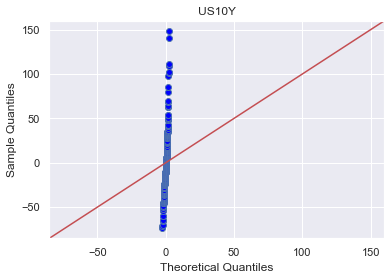

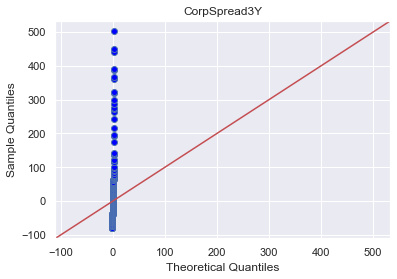

In [41]:
for i in monthly.columns[1:]:
    sm.qqplot(monthly[i], line ='45')
    plt.title(i)

## Check Stationarity (ADF Test)

In [42]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [43]:
for i in monthly.columns[1:]:
    print('-------------------------------------------------------')
    print('ADF Test: '+ i)
    adf_test(monthly[i])
    print('')

-------------------------------------------------------
ADF Test: M3
ADF Statistics: -1.253123
p-value: 0.650337
Critical values:
	1%: -3.455
	5%: -2.872
	10%: -2.573

-------------------------------------------------------
ADF Test: Unrate
ADF Statistics: -3.682401
p-value: 0.004368
Critical values:
	1%: -3.455
	5%: -2.872
	10%: -2.573

-------------------------------------------------------
ADF Test: PMI_R1
ADF Statistics: -4.024688
p-value: 0.001287
Critical values:
	1%: -3.455
	5%: -2.872
	10%: -2.573

-------------------------------------------------------
ADF Test: PMI_L1
ADF Statistics: -3.689830
p-value: 0.004259
Critical values:
	1%: -3.455
	5%: -2.872
	10%: -2.573

-------------------------------------------------------
ADF Test: PPI
ADF Statistics: -4.242125
p-value: 0.000559
Critical values:
	1%: -3.455
	5%: -2.873
	10%: -2.573

-------------------------------------------------------
ADF Test: CPI
ADF Statistics: -2.890299
p-value: 0.046488
Critical values:
	1%: -3.455
	5%:

# 环比结果

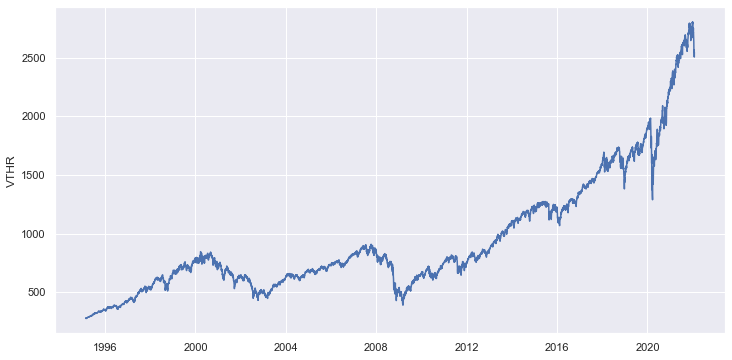

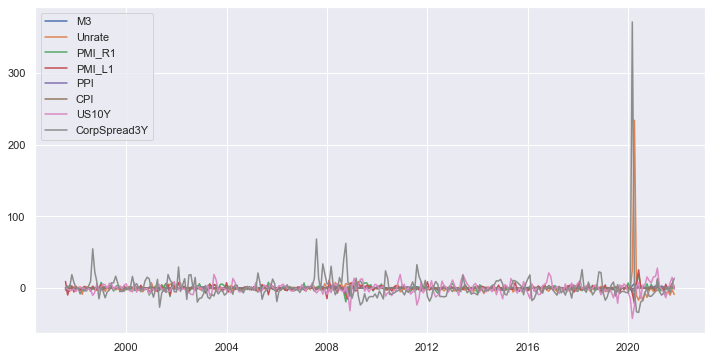

In [52]:
#计算环比数据
monthly = M2.join(M3, how='inner')
for i in monthly_list[2:]:
    i.index = pd.to_datetime(pd.to_datetime(i.index).strftime("%Y-%m"))
    monthly = monthly.join(i,how='inner')
    
for i in weekly_list:
    tmp = i.resample("M").mean()
    tmp.index = pd.to_datetime(tmp.index.strftime("%Y-%m"))
    monthly = monthly.join(tmp,how='inner')
    
monthly = monthly.dropna()

for i in monthly.columns[1:]:
    monthly[i] = monthly[i].pct_change(periods=1)*100
    
monthly = monthly.dropna()

plt.figure(figsize=(12, 6))
plt.plot( vthr['Price'])
plt.ylabel('VTHR')
plt.show()

plt.figure(figsize=(12, 6))
for i in monthly.columns[1:]:
    plt.plot( monthly[i], label=i)
plt.legend()    
plt.show()

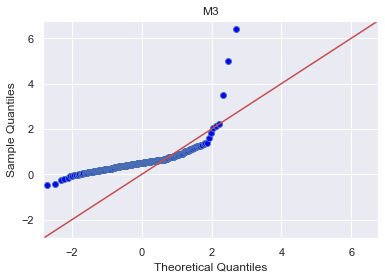

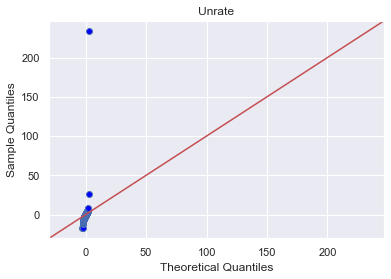

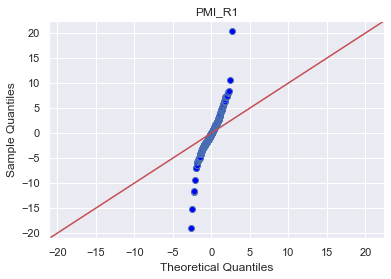

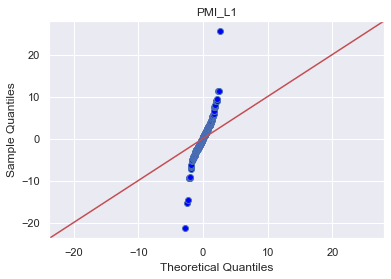

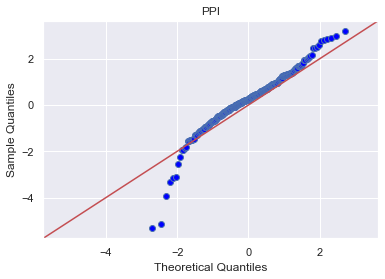

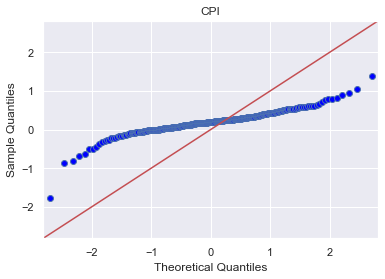

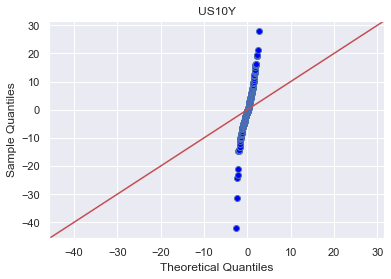

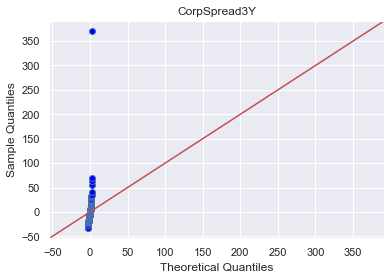

In [45]:
for i in monthly.columns[1:]:
    sm.qqplot(monthly[i], line ='45')
    plt.title(i)

In [46]:
for i in monthly.columns[1:]:
    print('-------------------------------------------------------')
    print('ADF Test: '+ i)
    adf_test(monthly[i])
    print('')

-------------------------------------------------------
ADF Test: M3
ADF Statistics: -5.477025
p-value: 0.000002
Critical values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

-------------------------------------------------------
ADF Test: Unrate
ADF Statistics: -15.764824
p-value: 0.000000
Critical values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

-------------------------------------------------------
ADF Test: PMI_R1
ADF Statistics: -15.837598
p-value: 0.000000
Critical values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

-------------------------------------------------------
ADF Test: PMI_L1
ADF Statistics: -15.770829
p-value: 0.000000
Critical values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

-------------------------------------------------------
ADF Test: PPI
ADF Statistics: -6.984323
p-value: 0.000000
Critical values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

-------------------------------------------------------
ADF Test: CPI
ADF Statistics: -4.887345
p-value: 0.000037
Critical values:
	1%: -3.454
	

# Granger Causality（f test）

In [53]:
vthr_m = vthr.resample("M").mean()
vthr_m.index = pd.to_datetime(vthr_m.index.strftime("%Y-%m"))
vthr_m['pct_m'] = vthr_m['Price'].pct_change(periods=1)*100
vthr_m = vthr_m.dropna()

monthly = monthly.join( vthr_m[['pct_m']], how='inner')
monthly.head()

,M2,M3,Unrate,PMI_R1,PMI_L1,PPI,CPI,US10Y,CorpSpread3Y,pct_m
Date,,,,,,,,,,
1997-08-01,3957.4,0.853742,-2.040816,-2.426343,9.439788,0.236407,0.249377,1.255807,0.111483,0.938904
1997-09-01,3973.1,0.396725,2.083333,-4.262877,-9.471987,0.235849,0.248756,-1.428895,3.011984,1.938763
1997-10-01,3992.3,0.483250,-4.081633,4.638219,0.801425,0.235294,0.186104,-2.883529,0.817372,1.737932
1997-11-01,4014.8,0.563585,-2.127660,-1.241135,3.356890,0.078247,0.123839,-2.563136,18.959707,-1.736434
1997-12-01,4032.9,0.450832,2.173913,-2.154399,-5.213675,-0.860047,0.061843,-1.129594,8.073654,2.187140


In [55]:
from statsmodels.tsa.stattools import grangercausalitytests
for i in monthly.columns[:-1]:
    print('-------------------------------------------------------')
    print(i)
    grangercausalitytests(monthly[[i,  'pct_m']], maxlag=12)

-------------------------------------------------------
M2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2013 , p=0.0003  , df_denom=288, df_num=1
ssr based chi2 test:   chi2=13.3388 , p=0.0003  , df=1
likelihood ratio test: chi2=13.0421 , p=0.0003  , df=1
parameter F test:         F=13.2013 , p=0.0003  , df_denom=288, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1723  , p=0.0024  , df_denom=285, df_num=2
ssr based chi2 test:   chi2=12.5611 , p=0.0019  , df=2
likelihood ratio test: chi2=12.2967 , p=0.0021  , df=2
parameter F test:         F=6.1723  , p=0.0024  , df_denom=285, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1791  , p=0.0065  , df_denom=282, df_num=3
ssr based chi2 test:   chi2=12.8486 , p=0.0050  , df=3
likelihood ratio test: chi2=12.5712 , p=0.0057  , df=3
parameter F test:         F=4.1791  , p=0.0065  , df_denom=282, df_num=3

Granger Causality
number of lags (

parameter F test:         F=6.1500  , p=0.0000  , df_denom=267, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.5955  , p=0.0000  , df_denom=264, df_num=9
ssr based chi2 test:   chi2=53.9841 , p=0.0000  , df=9
likelihood ratio test: chi2=49.4087 , p=0.0000  , df=9
parameter F test:         F=5.5955  , p=0.0000  , df_denom=264, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0236  , p=0.0000  , df_denom=261, df_num=10
ssr based chi2 test:   chi2=54.2785 , p=0.0000  , df=10
likelihood ratio test: chi2=49.6412 , p=0.0000  , df=10
parameter F test:         F=5.0236  , p=0.0000  , df_denom=261, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=4.5956  , p=0.0000  , df_denom=258, df_num=11
ssr based chi2 test:   chi2=55.0579 , p=0.0000  , df=11
likelihood ratio test: chi2=50.2790 , p=0.0000  , df=11
parameter F test:         F=4.5956  , p=0.0000  , df_denom=258, df_num=11

Granger Ca

parameter F test:         F=1.8558  , p=0.0402  , df_denom=255, df_num=12
-------------------------------------------------------
CorpSpread3Y

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9296  , p=0.0052  , df_denom=288, df_num=1
ssr based chi2 test:   chi2=8.0122  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9039  , p=0.0049  , df=1
parameter F test:         F=7.9296  , p=0.0052  , df_denom=288, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0813  , p=0.0179  , df_denom=285, df_num=2
ssr based chi2 test:   chi2=8.3058  , p=0.0157  , df=2
likelihood ratio test: chi2=8.1891  , p=0.0167  , df=2
parameter F test:         F=4.0813  , p=0.0179  , df_denom=285, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7095  , p=0.0454  , df_denom=282, df_num=3
ssr based chi2 test:   chi2=8.3303  , p=0.0397  , df=3
likelihood ratio test: chi2=8.2125  , p=0.0418  , df=3
parameter F test:       

# Test practice on AAPL technical indicators

In [7]:
aapl = yf.download('aapl')
aapl.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100453,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095213,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088224,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090408,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093029,73449600


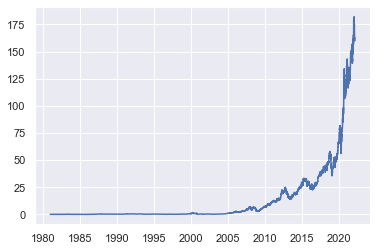

,open,high,low,close,Adj Close,volume,vwap,returns
Date,,,,,,,,
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095213,175884800,0.121652,-0.052171
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088224,105728000,0.112723,-0.073398
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090408,86441600,0.115513,0.024751
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093029,73449600,0.118862,0.028992
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098707,48630400,0.126116,0.061029


In [30]:
aapl.rename(columns={
                    'Open':'open',
                     'Close':'close',
                     'High':'high',
                     'Low':'low',
                    'Volume':'volume'}, inplace=True)
plt.plot(aapl['close'])
plt.show()
aapl['vwap'] = u.vwap(aapl)
aapl['returns'] = u.returns(aapl)
aapl = aapl.dropna()
aapl.head()

In [15]:
import time
start = time.time()
df = aapl[['returns']]
for n in range(20):
    name = 'alpha{}'.format(n+1)
    func = 'fg.{}'.format(name)
    try:
        temp_func = eval(func)
        df[name] = temp_func(aapl)
    except:
        print('error at:',func)
print('Time:{}s'.format(time.time()-start))
df = df.dropna()
df.head()

,returns,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,...,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha18,alpha19,alpha20
Date,,,,,,,,,,,,,,,,,,,,,
1981-12-16,0.046989,0.336200,0.089978,-0.347106,-1.000000,-0.262383,-0.489659,-0.400000,-0.494253,-0.003907,...,0.731955,-0.003907,-0.674998,-0.454508,-2.432111,-0.631477,-0.351017,-0.781908,-1.187191,-0.212251
1981-12-17,0.083328,0.336200,-0.122872,-0.039885,-1.000000,-0.312880,-0.114293,-0.833333,-0.597701,-0.007254,...,0.816607,0.007254,-0.654830,-0.113356,-2.150566,-0.606967,-0.276355,-0.818208,-1.198162,-0.314659
1981-12-18,0.082846,0.336200,-0.235268,-0.503953,-1.000000,-0.340881,-0.524165,-1.000000,-0.666667,-0.007813,...,0.839477,-0.007813,-0.805269,-0.488914,-1.684573,-0.772556,-0.425411,-0.840220,-1.217237,-0.326820
1981-12-21,-0.043723,0.077793,-0.408746,-0.480702,-0.888889,-0.318480,-0.542332,-0.900000,-0.652854,0.004465,...,0.736153,-0.004465,-0.750362,-0.009105,-1.703144,-0.713210,-0.105285,-0.837034,-1.170093,-0.008947
1981-12-22,0.017142,-0.100889,0.065367,-0.426912,-0.888889,-0.315873,-0.528813,-0.958333,-0.661451,-0.001674,...,0.764885,0.001674,-0.539226,-0.022859,-2.193925,-0.467529,-0.057711,-0.847364,-1.149733,-0.118837


## QQ Plot
Checking normality

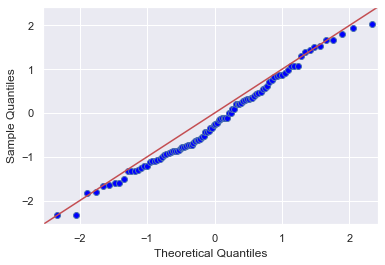

In [38]:
data_points = np.random.normal(0, 1, 100)    
  
sm.qqplot(data_points, line ='45')
plt.show()

<Figure size 432x288 with 0 Axes>

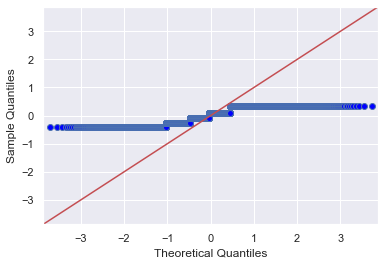

<Figure size 432x288 with 0 Axes>

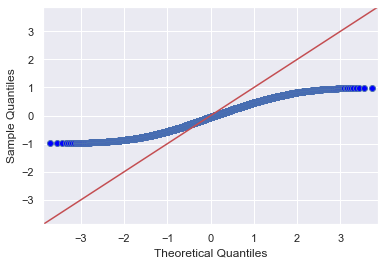

<Figure size 432x288 with 0 Axes>

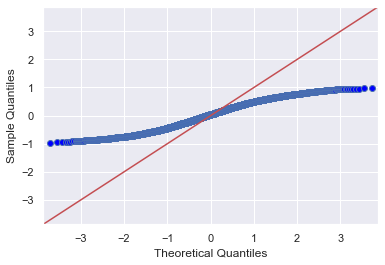

<Figure size 432x288 with 0 Axes>

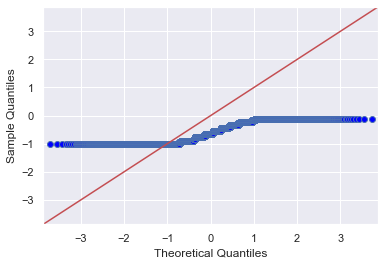

<Figure size 432x288 with 0 Axes>

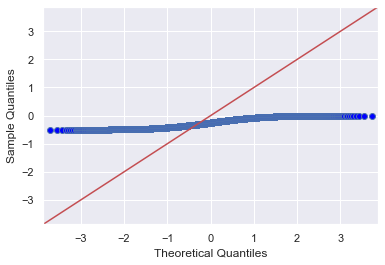

<Figure size 432x288 with 0 Axes>

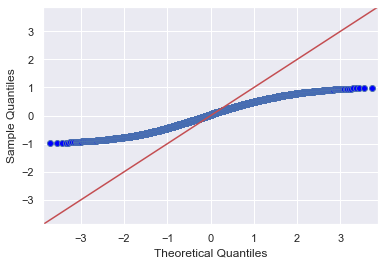

<Figure size 432x288 with 0 Axes>

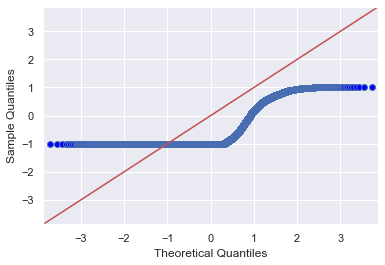

<Figure size 432x288 with 0 Axes>

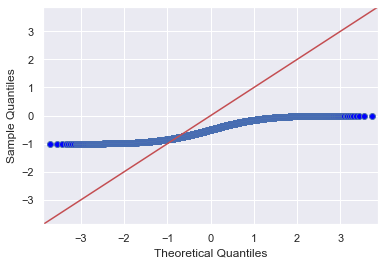

<Figure size 432x288 with 0 Axes>

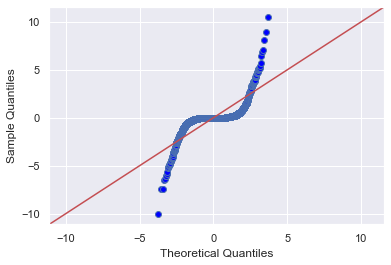

<Figure size 432x288 with 0 Axes>

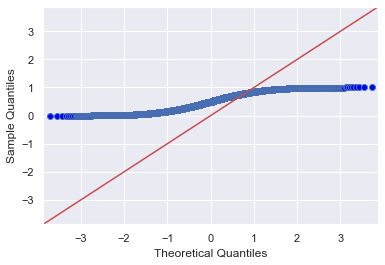

<Figure size 432x288 with 0 Axes>

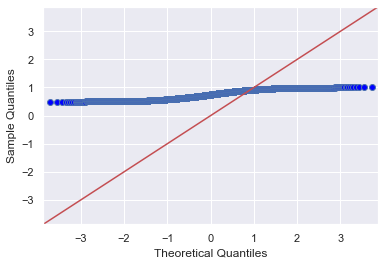

<Figure size 432x288 with 0 Axes>

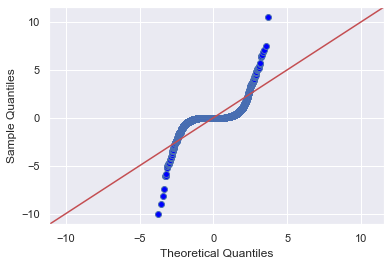

<Figure size 432x288 with 0 Axes>

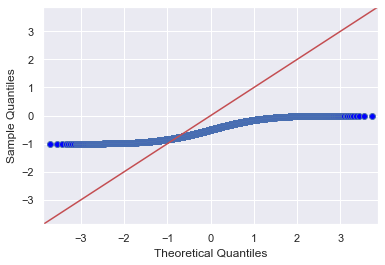

<Figure size 432x288 with 0 Axes>

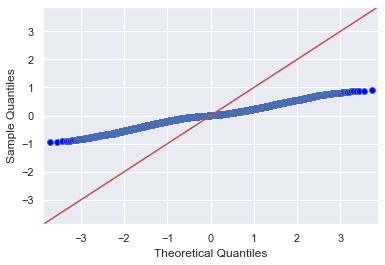

<Figure size 432x288 with 0 Axes>

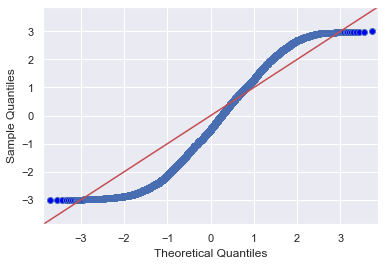

<Figure size 432x288 with 0 Axes>

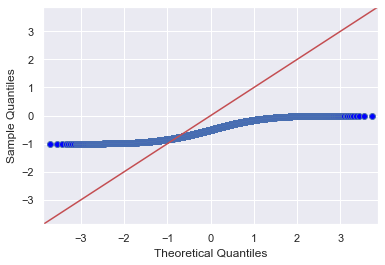

<Figure size 432x288 with 0 Axes>

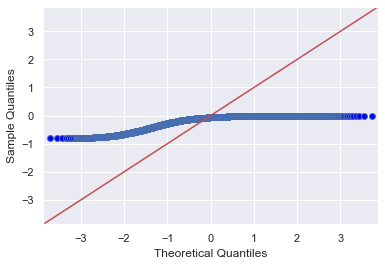

<Figure size 432x288 with 0 Axes>

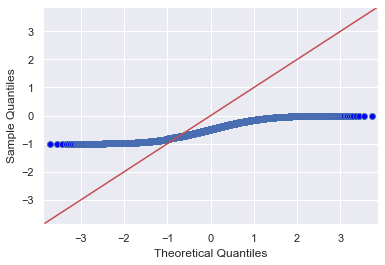

<Figure size 432x288 with 0 Axes>

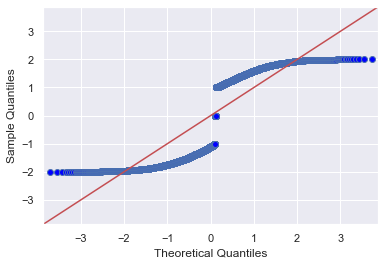

<Figure size 432x288 with 0 Axes>

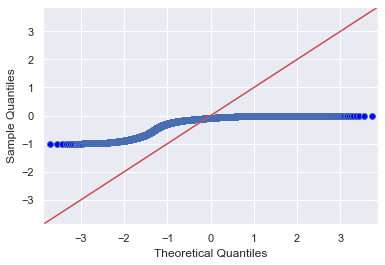

In [37]:
for i in range(1, 21):
    col = 'alpha'+ str(i)
    plt.figure()
    sm.qqplot(df[col], line ='45')
    plt.show()

In [13]:
# df.to_csv('alphas20_AAPL.csv', index=False)

In [ ]:
import scipy.stats as ss 
colnames = list(df.columns())
dp_t_mat = np.zeros([len(colnames), len(colnames)])
for i in range(len(colnames)):
    for j in range(len(colnames)):
        p_value = ss.ttest_ind(df['left'].iloc[dp_indices[dp_keys[i]]].values,
                              df['left'].iloc[dp_indices[dp_keys[j]]].values)[1]
        if p_value < 0.05:
            dp_t_mat[i][j] = -1                 #颜色越深，说明部门之间的离职率有显著差异（拒绝原假设）
        else:  
            dp_t_mat[i][j] = p_value
sns.heatmap(dp_t_mat, xticklabels=dp_keys, yticklabels=dp_keys)   

## Granger Causality Test
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Granger%20Causality%20Test.ipynb

In [19]:
# from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15
test = 'ssr_chi2test'
colnames = df.columns[:5]
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

t_mat = grangers_causation_matrix(df[colnames], variables = colnames)
t_mat

C:\Users\xiang\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\xiang\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\xiang\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
  warnings.warn('covariance of constraints does not have full '
C:\Users\xiang\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,returns_x,alpha1_x,alpha2_x,alpha3_x,alpha4_x
returns_y,1.0,0.0069,0.0213,0.1537,0.0
alpha1_y,0.0,1.0000,0.0710,0.0005,0.0
alpha2_y,0.0,0.0000,1.0000,0.0000,0.0
alpha3_y,0.0,0.0000,0.0000,1.0000,0.0
alpha4_y,0.0,0.0000,0.0000,0.0160,1.0


<AxesSubplot:>

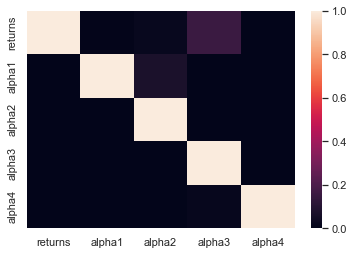

In [21]:
seaborn.heatmap(t_mat, xticklabels=colnames, yticklabels=colnames) 

## Variance Inflation Factor
Checking  Multicollinearity